In [1]:
import os
from glob import glob
import rasterio as rio
import numpy as np
from tqdm import tqdm,tqdm_notebook
from rasterio.plot import reshape_as_image,reshape_as_raster
import re
import pandas as pd
import json
import geopandas as gpd

import seaborn as sns
from rasterio.features import rasterize
import matplotlib.pyplot as plt
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [73]:
from sklearn.cluster import MiniBatchKMeans
from skimage.morphology import reconstruction
from rasterio.features import sieve
from rasterio.plot import reshape_as_image
from affine import Affine

def strat_rand_sampling(file,outf,size,nodat=0,seed=None):
    #set seed for numpy random 
    np.random.seed(seed)
    
    data = []
    with rio.open(file) as src:
        
        #translate rows, cols to xy coordinates
        T0 = src.transform
        T1 = T0 * Affine.translation(0.5, 0.5)
        rc2xy = lambda r, c: T1 * (c, r) 

        img = src.read(1)
        strata = np.unique(img)[np.unique(img)!=nodat]
        
        #sample each stratum to a geopanda dataframe
        for stratum in strata: 
            
            rows,cols = np.where(img==stratum)
            idx = np.random.choice(np.arange(len(rows)), size, replace=False)
            stratified_samples = np.array([rc2xy(x, y) for x,y in zip(rows[idx],cols[idx]) ])
            x,y = stratified_samples[:,0],stratified_samples[:,1]
            gdf = gpd.GeoDataFrame(crs=str(src.crs), geometry=gpd.points_from_xy(x,y))
            gdf['class'] = stratum
            data.append(gdf)
    
    data_cat = pd.concat(data,ignore_index=True)
    data_cat.to_file(outf,driver="GeoJSON")
    print(f'Exported as: {outf}')
    
def compute_rws(stack_arr,rws_type):
    np.seterr(divide='ignore', invalid='ignore')
    
    if rws_type == 'WIW':
        b8a = stack_arr[get_arr('b8a')].astype(np.float32)/10000
        b12 = stack_arr[get_arr('b12')].astype(np.float32)/10000
        rws = np.where( ((b8a>0)&(b8a<=0.1804)) & ((b12>0)&(b12<=0.1131)), 1, 0)

    elif rws_type == 'RWS':
        b3= stack_arr[get_arr('b3')].astype(np.float32)/10000
        b11 = stack_arr[get_arr('b11')].astype(np.float32)/10000
        mndwi = (b3-b11)/(b3+b11)
        mgrn = (stack_arr[get_arr(['b3','b4','b8'])].astype(np.float32)/10000).min(0)
        rws = np.where( (mndwi>0.3) &((mgrn>0) & (mgrn<0.15)),1,0)
    
    nodata_mask = np.where(stack_arr==0,1,0).max(0)
    rws_img = np.where((nodata_mask!=1) & (rws==1),stack_arr,0)
    return rws_img,rws
        
def compute_cluster(rws_rgb_img,k=4):
    samples = reshape_as_image(rws_rgb_img).reshape(-1,rws_rgb_img.shape[0])
    kmeans_pred = MiniBatchKMeans(n_clusters=k+1, random_state=42,max_iter=10,batch_size=10000,reassignment_ratio=0).fit(samples)
    kmeans_pred_img = kmeans_pred.labels_.reshape(rws_rgb_img.shape[1], rws_rgb_img.shape[2]).astype(rio.uint16)
    return kmeans_pred_img

def compute_mnws(img,cluster_img,bands=['B2','B3','B4','B8a','B11','B12']):
    
    band_pos = get_arr(bands)
    
    nodata = np.where(img[band_pos]==0,1,0).max(0)
    raw_img = np.where(nodata!=1,img[band_pos],0)

    mnws = []
    
    max_i = np.argmax(np.unique(cluster_img,return_counts=True)[1])
    all_labels = list(range(0,cluster_img.max()+1))
    labels = list(set(all_labels)-set([all_labels[max_i]]))

    for label in labels:
        
        #calculate band stats
        region_img = np.where(cluster_img==label,raw_img,0)
        band_means = np.array(list(map(lambda x:np.mean(region_img[x][region_img[x]!=0],dtype=np.float32),
                                       range(len(band_pos))))).reshape(len(band_pos),-1)
        band_std = np.array(list(map(lambda x:np.std(region_img[x][region_img[x]!=0],dtype=np.float32),
                                     range(len(band_pos))))).reshape(len(band_pos),-1)
        
        #calculate nws 
        reshaped_raw_img = raw_img.reshape(len(band_pos),-1)
        nws = (((((reshaped_raw_img-band_means)/band_std)**2).sum(0)/len(band_pos))**0.5).reshape(img.shape[1],img.shape[2])
        mnws.append(nws)
        
    mnws_img = np.array(mnws).min(0)
    mnws_img_clip = np.array([np.where(nodata!=1,mnws_img,0)])
    return mnws_img_clip

def multitemp_clmasks(target_img,reference_img):
    
    #cloud shadow = 1 and thick cloud = 2
    db8a = target_img[get_arr('b8a')]-reference_img[get_arr('b8a')]
    db11 = target_img[get_arr('b11')]-reference_img[get_arr('b11')]
    db2 = target_img[get_arr('b2')]-reference_img[get_arr('b2')]
    db3 = target_img[get_arr('b3')]-reference_img[get_arr('b3')]
    db4 = target_img[get_arr('b4')]-reference_img[get_arr('b4')]
    
    cl_shadow = np.where( (db8a<-400) & ( db11< -400 ),1,0)
    cl_thick = np.where( (db2>800) & (db3 >800) & (db4 >800),2,0)

    cl_masks = np.array([cl_shadow,cl_thick]).sum(0)
    cl_masks_sieved = sieve(cl_masks, size=30)
    return np.array([cl_masks_sieved]).astype(np.uint8)
        
def wcf_mnws(mnws_files,invalid_files,thr=3):
    
    water_rws_detected = []
    invalid_pixels = []    

    for i in tqdm(range(len(mnws_files)),position=0, leave=True):
        mnws_file = mnws_files[i]
        cl_mask_file = invalid_files[i]

        with rio.open(mnws_file) as src_mnws,rio.open(cl_mask_file ) as src_mask:
            profile = src_mnws.profile.copy()
            mnws_img = src_mnws.read(1)
            cl_mask = src_mask.read(1)

            invalid = np.where(cl_mask>0,1,0)
            invalid_pixels.append(invalid)

            water_rws = np.where((mnws_img<thr)&(mnws_img>0),1,0)
            water_rws = np.where(cl_mask==1,0,water_rws)
            water_rws_detected.append(water_rws)

    water_rws_detected_sum = np.array(water_rws_detected).sum(0)
    invalid_pixels_sum = np.array(invalid_pixels).sum(0)
    diff_invalid = len(mnws_files)-invalid_pixels_sum

    water_freq_img = np.true_divide(water_rws_detected_sum , diff_invalid, where=(diff_invalid!=0),dtype=np.float32)*12
    water_freq_img_r = np.round(water_freq_img,2)
    
    #reclassify to a thematic map (dynamic water map)
    dwm = water_freq_img_r.copy().astype(np.uint8)
    dwm[  np.where( (water_freq_img_r<0.5)&(water_freq_img_r>0) )  ] = 3
    dwm[  np.where( (water_freq_img_r>=0.5)&(water_freq_img_r<=11) )  ] = 2
    dwm[  np.where( (water_freq_img_r>11)&(water_freq_img_r<=12) )  ] = 1
    dwm[  np.where( (water_freq_img_r>12) )  ] = 99
    
    return water_freq_img_r,dwm,profile

def wcf_binary(binary_files,invalid_files):
    
    water_detected = []
    invalid_pixels = []    

    for i in tqdm(range(len(binary_files)),position=0, leave=True):
        binary_file = binary_files[i]
        cl_mask_file = invalid_files[i]

        with rio.open(binary_file) as src_bin,rio.open(cl_mask_file ) as src_mask:
            profile = src_bin.profile.copy()
            bin_img = src_bin.read(1)
            cl_mask = src_mask.read(1)

            invalid = np.where(cl_mask>0,1,0)
            invalid_pixels.append(invalid)

            water = np.where(cl_mask==1,0,bin_img)
            water_detected.append(water)

    water_detected_sum = np.array(water_detected).sum(0)
    invalid_pixels_sum = np.array(invalid_pixels).sum(0)
    diff_invalid = len(binary_files)-invalid_pixels_sum

    water_freq_img = np.true_divide(water_detected_sum , diff_invalid, where=(diff_invalid!=0),dtype=np.float32)*12
    water_freq_img_r = np.round(water_freq_img,2)
    
    #reclassify to a thematic map (dynamic water map)
    dwm = water_freq_img_r.copy().astype(np.uint8)
    dwm[  np.where( (water_freq_img_r<0.5)&(water_freq_img_r>0) )  ] = 3
    dwm[  np.where( (water_freq_img_r>=0.5)&(water_freq_img_r<=11) )  ] = 2
    dwm[  np.where( (water_freq_img_r>11)&(water_freq_img_r<=12) )  ] = 1
    dwm[  np.where( (water_freq_img_r>12) )  ] = 99
    
    return water_freq_img_r,dwm,profile

def get_arr(bands):
    band_names = ['B2','B3','B4','B5','B6','B7','B8','B8A','B10','B11','B12']
    if isinstance(bands,list):
        return [band_names.index(band.upper()) for band in bands]
    else:
        return band_names.index(bands.upper())

In [ ]:
%%time
#mnws computation
mosaics = glob(f'{os.path.abspath("..")}images/*.tif')
for i in tqdm(range(len(mosaics)),position=0, leave=True):
    file = mosaics[i]
    outf = f'{os.path.abspath("..")}results/rws_mnws/rws_{os.path.basename(file)}'.replace('mosaic','mnws')

    with rio.open(file) as src:
        profile = src.profile.copy()
        img = src.read()

        #mnws computations
        rws_img,_ = compute_rws(img,'RWS')
        cluster_img = compute_cluster(rws_img[get_arr(['b2','b3','b4'])],k=8)
        mnws_img = compute_mnws(img,cluster_img,['b2','b3','b4','b8a','b11','b12'])
        
        #export as geotiff
        profile.update({'dtype':mnws_img.dtype,'nodata':0,'count':mnws_img.shape[0]})
        with rio.open(outf,'w',**profile) as dst:
            dst.write(mnws_img)
        

In [ ]:
mosaics = glob(f'{os.path.abspath("..")}images/*.tif')
#wiw computation
for i in tqdm(range(len(mosaics)),position=0, leave=True):
    file = mosaics[i]
    outf = f'{os.path.abspath("..")}results/wiw/{os.path.basename(file)}'.replace('mosaic','wiw')
    
    with rio.open(file) as src:
        profile = src.profile.copy()
        img = src.read()

        #mnws computations
        _,wiw = compute_rws(img,'WIW')
        wiw = np.array([wiw])
        
        #export as geotiff
        profile.update({'dtype':wiw .dtype,'nodata':0,'count':wiw .shape[0]})
        with rio.open(outf,'w',**profile) as dst:
            dst.write(wiw)


In [ ]:
#cloud masks computation
mosaics = glob(f'{os.path.abspath("..")}images/*.tif')

#reference image (median composite)
ref_file = f'{os.path.abspath("..")}results/42mosaics_median_composite.tif'
src_mask = rio.open(ref_file)
mask = src_mask.read().astype(int)

for i in tqdm(range(len(mosaics)),position=0, leave=True):
    file = mosaics[i]
    outf = f'{os.path.abspath("..")}results/cloud_masks/{os.path.basename(file)}'.replace('mosaic','cl_mask')

    with rio.open(file) as src:
        profile = src.profile.copy()
        img = src.read()
        cl_masks = multitemp_clmasks(img,mask)
        
        #export as geotiff
        profile.update({'dtype':cl_masks.dtype,'nodata':0,'count':cl_masks.shape[0]})
        with rio.open(outf,'w',**profile) as dst:
            dst.write(cl_masks)
            
src_mask.close()

In [ ]:
%%time
#input files
mnws_files = glob(f"{os.path.abspath('..')}results/rws_mnws/*mnws*.tif")
wiw_files = glob(f"{os.path.abspath('..')}results/wiw/wiw*.tif")
cl_mask_files = glob(f"{os.path.abspath('..')}results/cloud_masks/cl*.tif")

#water rws frequency  
wf_rws,dwm_rws,profile = wcf_mnws(mnws_files,cl_mask_files,thr=3)

out_wf = f"{os.path.abspath('..')}results/wf_rws.tif"
profile.update({'dtype':wf_rws.dtype,'nodata':0,'count':1})
with rio.open(out_wf,'w',**profile) as dst: dst.write(np.array([wf_rws]))

out_dwm = f"{os.path.abspath('..')}results/dwm_rws.tif"
profile.update({'dtype':dwm_rws.dtype,'nodata':0,'count':1})
with rio.open(out_dwm,'w',**profile) as dst: dst.write(np.array([dwm_rws]))

#water wiw frequency  
wf_wiw,dwm_wiw,profile = wcf_binary(wiw_files,cl_mask_files)

out_wf = f"{os.path.abspath('..')}results/wf_wiw.tif"
profile.update({'dtype':wf_wiw.dtype,'nodata':0,'count':1})
with rio.open(out_wf,'w',**profile) as dst: dst.write(np.array([wf_wiw]))

out_dwm = f"{os.path.abspath('..')}results/dwm_wiw.tif"
profile.update({'dtype':dwm_wiw.dtype,'nodata':0,'count':1})
with rio.open(out_dwm,'w',**profile) as dst: dst.write(np.array([dwm_wiw]))



In [ ]:
# #compute non-water pixels from MNWS time-series
# #if a pixel satisfy sum(MNWS<3)=0 than its classified as a potential water pixel
# #else its a potential non-water pixel

# mnws_dir = f'{os.path.abspath("..")}results/rws_mnws'
# mosaics = glob(mnws_dir+"/*mnws*.tif")

# mnws_sum = []
# for i in tqdm(range(len(mosaics)),position=0, leave=True):
#     file = mosaics[i]
#     with rio.open(file) as src:
#         profile = src.profile.copy()
#         mnws_img = src.read(1)
#         mnws_img_thr = np.where((mnws_img<3)&(mnws_img>0),1,0)
#         mnws_sum.append(mnws_img_thr)
    
# mnws_sum = np.array(mnws_sum).sum(0)
# mnws_sum = np.where(mnws_sum>0,1,0)
# mnws_sum = np.array([mnws_sum])

# # #export as geotiff
# outf = f'{os.path.abspath("..")}results/nonwater_img.tif'
# profile.update({'dtype':mnws_sum.dtype,'nodata':99,'count':mnws_sum.shape[0]})
# with rio.open(outf,'w',**profile) as dst:
#     dst.write(mnws_sum)

In [ ]:
# #create stratified random sample
# file = f'{os.path.abspath("..")}results/water_freq_rws_img_v3_classified.tif'
# data  = strat_rand_sampling(file=file,outf='sample.geojson',size=100,nodat=0,seed=42)


10

In [51]:
def mnws_boxplot(data):
    plt.figure(figsize=(10,5))
    sns.set_style('darkgrid',rc={"xtick.bottom" : True, "ytick.left" : True,'axes.edgecolor': 'black'})
    flierprops = dict(marker='o',markerfacecolor='red', markersize=5,markeredgecolor='white')
    sns.boxplot(data=data,order=['Wa','Sh','Ds','Ve','Ag','Se','Bs','Cl'],flierprops=flierprops,whis=[5, 95],orient='h',palette='husl',linewidth=1)
    plt.xlabel('MNWS',fontsize=16)
    plt.ylabel('Land cover',fontsize=16)
    plt.title('MNWS land cover types 25 Feb 2017 ',fontsize=20)
    plt.xticks(range(0, int(data['Cl'].max()), 5))
    plt.axvline(3, 8,0,ls='--',color='black',lw=2)
    plt.show()

def plot_bands(band_data_mean,band_data_std):
    sns.set_style('darkgrid',rc={"xtick.bottom" : True, "ytick.left" : True,'axes.edgecolor': 'black'})
    plt.figure(figsize=(10,7))
    colors=['blue','orange','brown','yellow','green','purple','red','black']
    axs = [sns.lineplot(data=band_data.loc[band_data.index[i]]/10000,sort=False,color=colors[i]) for i in range(len(band_data.index))]
    axs[0].lines[0].set_linestyle("--")
    plt.legend(band_data.index,loc='upper right')
    plt.xlabel('Band',fontsize=16)
    plt.ylabel('Top of Atmosphere (TOA) Reflectance',fontsize=16)
    plt.title('Spectral signature land cover types 25 Feb 2017 ',fontsize=20)


    plt.fill_between(band_names,(band_data.iloc[0]/10000)-(band_data_std.iloc[0]/10000), (band_data.iloc[0]/10000)+(band_data_std.iloc[0]/10000), alpha=.3)
    plt.fill_between(band_names,(band_data.iloc[-1]/10000)-(band_data_std.iloc[-1]/10000), (band_data.iloc[-1]/10000)+(band_data_std.iloc[-1]/10000), alpha=.3,color=colors[-1])

    plt.show()

In [107]:
%%time

# MNWS and band stats example 25 Feb 2017
gdf = gpd.read_file(glob('./data/sample/sample*.geojson')[0])
labels = dict(zip(gdf ['code'].unique(),gdf ['desc'].unique()))
geom_code = list((zip(gdf ['geometry'].tolist(), gdf ['code'].tolist() )))

mosaics = glob(f'{os.path.abspath("..")}images/*.tif')
band_names = ['B2','B3','B4','B5','B6','B7','B8','B8A','B11','B12']

with rio.open(mosaics[3]) as src:

    img = src.read()
    img_bands = img[get_arr(band_names)]
    
    #band stats
    sample_mask = rasterize(shapes=geom_code, out_shape=src.shape, transform=src.transform)
    band_data = pd.concat([pd.DataFrame(img_bands[:,sample_mask==code].mean(1),columns=[desc]) for code,desc in labels.items()],axis=1).T
    band_data.columns = band_names
    band_data_std = pd.concat([pd.DataFrame(img_bands[:,sample_mask==code].std(1),columns=[desc]) for code,desc in labels.items()],axis=1).T
    band_data_std.columns = band_names
    
    #mnws computations
    rws_img,rws = compute_rws(img,'RWS')
    cluster_img = compute_cluster(rws_img[get_arr(['b2','b3','b4'])],k=8)
    mnws_img = compute_mnws(img,cluster_img,['B2','B3','B4','B11','B12'])
    mnws_data = pd.concat([pd.DataFrame(mnws_img[:,sample_mask==code]).T for code in list(labels.keys())],axis=1)
    mnws_data.columns = list(labels.values())



Wall time: 44.8 s


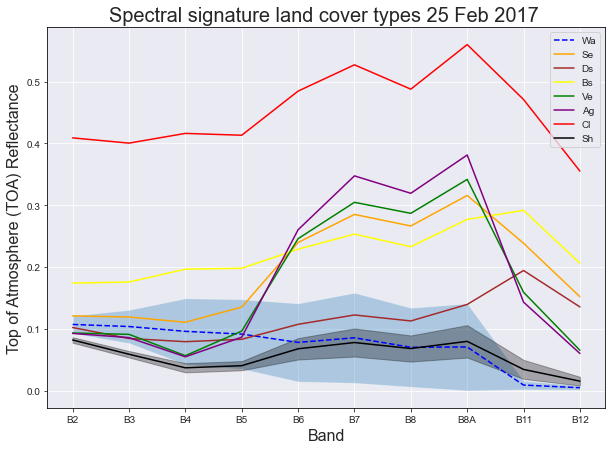

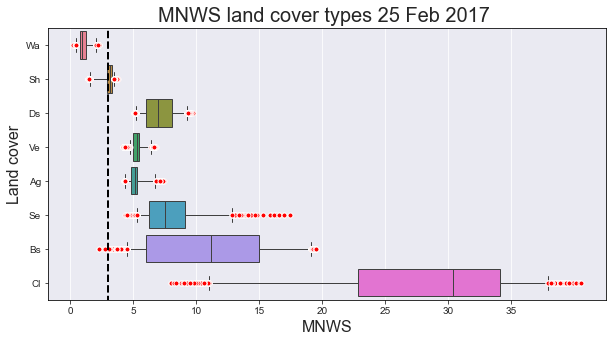

,mean,std,min,max
Wa,1.022,0.420,0.229,2.308
Sh,2.996,0.543,1.374,3.749
Ag,5.234,0.734,4.279,7.427
Ve,5.288,0.461,4.151,6.774
Ds,7.020,1.252,5.016,9.771
Se,7.982,2.314,4.337,17.410
Bs,11.008,4.861,2.298,19.515
Cl,27.798,8.339,8.024,40.529


In [106]:
plot_bands(band_data,band_data_std)
mnws_boxplot(mnws_data)
round(mnws_data.describe(),3).loc[['mean','std','min','max']].T.sort_values('mean')

100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [00:01<00:00, 21.63it/s]


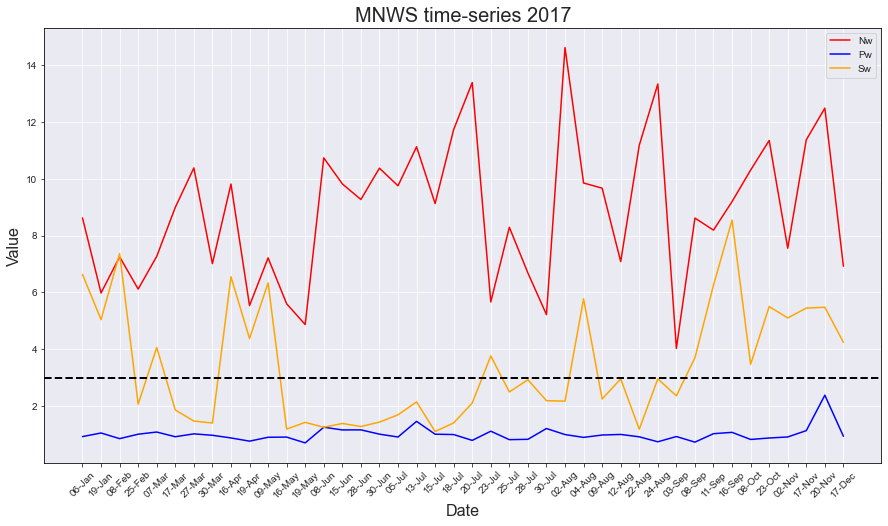

In [267]:
#compute  MNWS time-series
mnws_dir = f'{os.path.abspath("..")}results/rws_mnws'
mosaics = glob(mnws_dir+"/*mnws*.tif")
ts_sample = glob('./data/sample/ts_sample*.geojson')[0]
geo_ts_sample = gpd.read_file(ts_sample)
coords = list((zip(geo_ts_sample['geometry'].centroid.x,geo_ts_sample['geometry'].centroid.y)))

dates=[]

for i in tqdm(range(len(mosaics)),position=0, leave=True):
    file = mosaics[i]
    date = re.findall(r"(\d{8})", file)[0]
    dates.append(date)
    col_name = f'mnws_{date}'
    with rio.open(file) as src:
        
        #sample mnws time-series
        geo_ts_sample[col_name] = [val[0] for val in src.sample(coords)]

geo_ts_sample.iloc[:,4:] = geo_ts_sample.iloc[:,4:].round(3)

plt.figure(figsize=(15,8))
sns.set_style('darkgrid',rc={"xtick.bottom" : True, "ytick.left" : True,'axes.edgecolor': 'black'})
ax = sns.lineplot(data=geo_ts_sample.groupby(['desc']).median().T.iloc[2:,:],palette=['red','blue','orange'])
[ax.lines[i].set_linestyle("-") for i in range(3)]
plt.legend(geo_ts_sample.groupby(['desc']).median().T.iloc[2:,:].columns[0:],loc='upper right')
ax.set_xticklabels(pd.to_datetime(pd.Series(dates)).dt.strftime('%d-%b'))
plt.axhline(3, 8,0,ls='--',color='black',lw=2)
plt.xticks(rotation=45)
plt.xlabel('Date',fontsize=16)
plt.ylabel('Value',fontsize=16)
plt.title('MNWS time-series 2017',fontsize=20)
plt.show()

In [257]:
from scipy.ndimage import label
array = geo_ts_sample.groupby(['desc']).median().T.iloc[2:,:]['Sw']

high = label((array>3))[1]
low = label((array<3))[1]
print(high+low-1)

10


In [347]:
mnws_files = glob(f"{os.path.abspath('..')}results/rws_mnws/*mnws*.tif")
cl_mask_files = glob(f"{os.path.abspath('..')}results/cloud_masks/cl*.tif")

mnws_files = mnws_files[3:6]
cl_mask_files = cl_mask_files[3:6]

# for file in mnws_files:

#     with rio.open(mnws_files[3]) as src,rio.open(cl_mask_files[3]) as src_mask:
#         mnws_img = src.read()
#         mask = src_mask.read()
